In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Data prep

In [2]:
import pandas as pd
from math import isnan

from tqdm.auto import tqdm, trange

train_seq_df = pd.read_csv("./datasets/stanford-rna-3d-folding-2/train_sequences.csv")
train_label_df = pd.read_csv("./datasets/stanford-rna-3d-folding-2/train_labels.csv")

train_label_df["chain"] = train_label_df["chain"].astype(str)
train_label_df['target_id'] = train_label_df['ID'].str.split('_', n=1).str[0]

nan_mask = train_label_df[['x_1','y_1','z_1']].isna().any(axis=1)
train_label_df['valid'] = ~nan_mask

train_label_df = train_label_df.sort_values(["target_id", "chain", "copy", "resid"]).reset_index(drop=True)

train_label_df.head()

/tmp/ipykernel_130614/2654761357.py:7: DtypeWarning: Columns (0: chain) have mixed types. Specify dtype option on import or set low_memory=False.
  train_label_df = pd.read_csv("./datasets/stanford-rna-3d-folding-2/train_labels.csv")


,ID,resname,resid,x_1,y_1,z_1,chain,copy,target_id,valid
0,157D_1,C,1,4.843,-5.640,13.265,A,1,157D,True
1,157D_2,G,2,3.385,-7.613,8.267,A,1,157D,True
2,157D_3,C,3,2.158,-6.751,2.949,A,1,157D,True
3,157D_4,G,4,2.669,-4.843,-1.773,A,1,157D,True
4,157D_5,A,5,3.509,0.239,-4.045,A,1,157D,True


In [3]:
valid_seq_df = pd.read_csv("./datasets/stanford-rna-3d-folding-2/validation_sequences.csv")
valid_label_df = pd.read_csv("./datasets/stanford-rna-3d-folding-2/validation_labels.csv")

valid_label_df["chain"] = valid_label_df["chain"].astype(str)
valid_label_df['target_id'] = valid_label_df['ID'].str.split('_', n=1).str[0]

nan_mask = valid_label_df[['x_1','y_1','z_1']].isna().any(axis=1) | (valid_label_df[['x_1','y_1','z_1']] <= -1e17).any(axis=1)
valid_label_df['valid'] = ~nan_mask

valid_label_df = valid_label_df.sort_values(["target_id", "chain", "copy", "resid"]).reset_index(drop=True)

valid_label_df = valid_label_df.copy()
valid_label_df.head()

/tmp/ipykernel_130614/3724868088.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid_label_df['target_id'] = valid_label_df['ID'].str.split('_', n=1).str[0]
/tmp/ipykernel_130614/3724868088.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid_label_df['valid'] = ~nan_mask


,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,...,y_39,z_39,x_40,y_40,z_40,chain,copy,Usage,target_id,valid
0,8ZNQ_1,A,1,-2.054,-15.062,20.736,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,A,1,Public,8ZNQ,True
1,8ZNQ_2,C,2,-1.971,-15.076,15.338,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,A,1,Public,8ZNQ,True
2,8ZNQ_3,C,3,-3.350,-13.497,10.444,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,A,1,Public,8ZNQ,True
3,8ZNQ_4,G,4,-5.443,-11.044,6.605,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,A,1,Public,8ZNQ,True
4,8ZNQ_5,U,5,-6.350,-6.269,4.550,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,A,1,Public,8ZNQ,True


In [4]:
# Map a 3 letter sequence to
# a value for embedding
def get_token_map():
    token_map = {}
    tokens = "ACGU "
    i = 1
    for c1 in tokens:
        for c2 in tokens:
            if c2 == ' ':
                continue
            for c3 in tokens:
                token_map[c1 + c2 + c3] = i
                i += 1
    return token_map

token_map = get_token_map()

print(token_map)

{'AAA': 1, 'AAC': 2, 'AAG': 3, 'AAU': 4, 'AA ': 5, 'ACA': 6, 'ACC': 7, 'ACG': 8, 'ACU': 9, 'AC ': 10, 'AGA': 11, 'AGC': 12, 'AGG': 13, 'AGU': 14, 'AG ': 15, 'AUA': 16, 'AUC': 17, 'AUG': 18, 'AUU': 19, 'AU ': 20, 'CAA': 21, 'CAC': 22, 'CAG': 23, 'CAU': 24, 'CA ': 25, 'CCA': 26, 'CCC': 27, 'CCG': 28, 'CCU': 29, 'CC ': 30, 'CGA': 31, 'CGC': 32, 'CGG': 33, 'CGU': 34, 'CG ': 35, 'CUA': 36, 'CUC': 37, 'CUG': 38, 'CUU': 39, 'CU ': 40, 'GAA': 41, 'GAC': 42, 'GAG': 43, 'GAU': 44, 'GA ': 45, 'GCA': 46, 'GCC': 47, 'GCG': 48, 'GCU': 49, 'GC ': 50, 'GGA': 51, 'GGC': 52, 'GGG': 53, 'GGU': 54, 'GG ': 55, 'GUA': 56, 'GUC': 57, 'GUG': 58, 'GUU': 59, 'GU ': 60, 'UAA': 61, 'UAC': 62, 'UAG': 63, 'UAU': 64, 'UA ': 65, 'UCA': 66, 'UCC': 67, 'UCG': 68, 'UCU': 69, 'UC ': 70, 'UGA': 71, 'UGC': 72, 'UGG': 73, 'UGU': 74, 'UG ': 75, 'UUA': 76, 'UUC': 77, 'UUG': 78, 'UUU': 79, 'UU ': 80, ' AA': 81, ' AC': 82, ' AG': 83, ' AU': 84, ' A ': 85, ' CA': 86, ' CC': 87, ' CG': 88, ' CU': 89, ' C ': 90, ' GA': 91, ' GC': 

In [5]:
import math

def build_delta_map(df):
    id_map = {}
    total = 0
    min_found = 0
    max_found = 0
    # Builds a mask where NaNs are [None, None, None]
    for row in tqdm(df.itertuples(index=False), desc = "Build id->coordinate map", total=len(df)):
        key = (row.target_id, row.chain, row.copy)
        if not row.valid:
            id_map.setdefault(key, []).append([None,None,None])
        else:
            id_map.setdefault(key, []).append([row.x_1,row.y_1,row.z_1])

    # Calculates relative distances and handles NaNs
    # for shape in tqdm(id_map.values(), desc="Calculate deltas"):
    #     abs_coords = [p.copy() if p[0] is not None else None for p in shape]
    
    #     prev_abs = None
    
    #     for i in range(len(shape)):
    #         if abs_coords[i] is None:
    #             shape[i] = [None, None, None]
    #             prev_abs = None
    #             continue
    
    #         if prev_abs is None:
    #             shape[i] = [None, None, None]
    #         else:
    #             shape[i] = [abs_coords[i][j] - prev_abs[j] for j in range(3)]
    
    #         prev_abs = abs_coords[i]

    return id_map

def get_stds(id_map):
    sx = sy = sz = 0.0
    n = 0

    for shape in id_map.values():
        for x,y,z in shape:
            if x is None: continue
            sx += x*x
            sy += y*y
            sz += z*z
            n += 1

    std_x = math.sqrt(sx / n) or 1.0
    std_y = math.sqrt(sy / n) or 1.0
    std_z = math.sqrt(sz / n) or 1.0

    print(f"std : ({std_x:.4f}, {std_y:.4f}, {std_z:.4f})")
    return std_x, std_y, std_z

def normalize(id_map, std_x, std_y, std_z):
    total = 0
    min_found = float("inf")
    max_found = float("-inf")
    n = 0

    for shape in tqdm(id_map.values(), desc="Normalize deltas"):
        for p in shape:
            if p[0] is None:
                continue

            p[0] /= std_x
            p[1] /= std_y
            p[2] /= std_z

            total += math.sqrt(p[0]**2 + p[1]**2 + p[2]**2)
            min_found = min(min_found, p[0], p[1], p[2])
            max_found = max(max_found, p[0], p[1], p[2])
            n += 1

    print("Average subcomponent magnitude:", total / n)
    print("Min:", min_found)
    print("Max:", max_found)

    return id_map

train_map = build_delta_map(train_label_df)
valid_map = build_delta_map(valid_label_df)

stds = get_stds(train_map)

train_map = normalize(train_map, *stds)
valid_map = normalize(valid_map, *stds)

# Map (target_id, chain, copy) to a list of
# coordinates representing the shape produced

Build id->coordinate map:   0%|          | 0/7794971 [00:00<?, ?it/s]

Build id->coordinate map:   0%|          | 0/9762 [00:00<?, ?it/s]

std : (213.1497, 212.8262, 207.3829)


Normalize deltas:   0%|          | 0/17905 [00:00<?, ?it/s]

Average subcomponent magnitude: 1.559521499174416
Min: -4.4135744661340635
Max: 6.317545359570798


Normalize deltas:   0%|          | 0/47 [00:00<?, ?it/s]

Average subcomponent magnitude: 1.700205222690916
Min: -0.4871928419346351
Max: 2.028373413067239


In [6]:
def get_example_df(id_map):
    examples = []
    for (tid, chain, copy), coords in tqdm(id_map.items()):
        examples.append({
            "target_id": tid,
            "chain": chain,
            "copy": copy,
            "length": len(coords)
        })
    
    return pd.DataFrame(examples)

train_examples_df = get_example_df(train_map)
valid_examples_df = get_example_df(valid_map)

# Drop everything that Kabsch simply can't handle
train_examples_df = train_examples_df.drop(train_examples_df[train_examples_df['length'] < 3].index)
valid_examples_df = valid_examples_df.drop(valid_examples_df[valid_examples_df['length'] < 3].index)

train_examples_df.reset_index(drop=True)
valid_examples_df.reset_index(drop=True)

train_examples_df.head()
valid_examples_df.head()

  0%|          | 0/17905 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

,target_id,chain,copy,length
0,8ZNQ,A,1,30
1,9CFN,A,1,59
2,9E74,A,1,255
3,9E75,A,1,165
4,9E9Q,A,1,101


In [7]:
import sys
sys.path.append("./datasets/stanford-rna-3d-folding-2/extra")

from parse_fasta_py import parse_fasta

# Builds a map of
# (ID, chain) -> sequence
def build_seq_map(df):
    seq_map = {}
    for _, row in tqdm(df.iterrows(), total=len(df)):
        chains = parse_fasta(row["all_sequences"])
        for primary_chain, (seq, chain_list) in chains.items():
            for ch in chain_list:
                seq_map[(row["target_id"], ch)] = seq
    return seq_map

train_seq_map = build_seq_map(train_seq_df)
valid_seq_map = build_seq_map(valid_seq_df)

  0%|          | 0/5716 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

In [8]:
max_seq_len = 0
for seq in train_seq_map.values():
    max_seq_len = max(max_seq_len, len(seq))
max_seq_len += 2 # Because of padding each side
print("Longest sequence:", max_seq_len)

Longest sequence: 5229


# Data loader

In [9]:
from ember import Learner

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from collections import deque
from time import time

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cuda.enable_flash_sdp(True)

In [10]:
bs = 2
test_bs = 1
num_epochs = 10

In [11]:
def split_str(k, s):
    return [s[i:i+k] for i in range(len(s)-k+1)]

In [12]:
def get_seq_by_id(id: str) -> str:
    if '_' in id:
        id = id.split('_')[0]
    for i, row in train_seq_df.iterrows():
        if row['target_id'] == id:
            return row['sequence']
    return None

In [13]:
def encode(seq: str):
    str_tokens = split_str(3, seq)
    tokens = [token_map[key] for key in str_tokens]
    return torch.tensor(tokens, dtype=torch.long)

In [14]:
class TensorWrapper():
    def __init__(self, *args):
        self.x = args

    def to(self, device, **kargs):
        self.x = tuple(x.to(device, **kargs) for x in self.x)
        return self

    def get(self):
        return self.x

In [15]:
class RNADataset(Dataset):
    def __init__(self, example_df, id_map, seq_map):
        self.examples = example_df
        self.id_map = id_map
        self.seq_map = seq_map

        self.examples = self.examples[self.examples.apply(self.has_any_valid, axis=1)].reset_index(drop=True)

        # Load this stuff into numpy so it's just an array index
        # instead of a dataframe index which is way slower
        self.target_ids = self.examples["target_id"].to_numpy()
        self.chains     = self.examples["chain"].to_numpy()
        self.copies     = self.examples["copy"].to_numpy()

        print(f"Found {len(self):,} data points")

    def has_any_valid(self, row):
        key = (row["target_id"], row["chain"], row["copy"])
    
        coords = self.id_map.get(key)
        if coords is None:
            return False
    
        return sum(c[0] is not None for c in coords) >= 3
        
    def __getitem__(self, idx):
        # Get the row from the examples dataframe
        target_id = self.target_ids[idx]
        chain     = self.chains[idx]
        copy      = self.copies[idx]

        # Construct the key and get a list of coordinates
        key = (target_id, chain, copy)
        coords = self.id_map[key]

        # Get the sequence of the coordinates
        # Pad each side so that the output head N is for the central
        # nucleotide in 3mer N
        seq = ' ' + self.seq_map[(target_id, chain)] + ' '
        raw_seq = encode(seq)

        clean = []
        valid_flags = []

        # Sanitize data to remove NaNs
        # but making sure to mask them out
        for c in coords:
            if c[0] is None:
                clean.append([0.0, 0.0, 0.0])
                valid_flags.append(False)
            else:
                clean.append(c)
                valid_flags.append(True)

        L = len(clean)

        target = torch.tensor(clean, dtype=torch.float32)
        is_valid = torch.tensor(valid_flags, dtype=torch.bool)

        seq_tensor = torch.zeros(max_seq_len, dtype=torch.long)
        target_tensor = torch.zeros(max_seq_len, 3, dtype=torch.float32)
        valid_tensor = torch.zeros(max_seq_len, dtype=torch.bool)

        seq_tensor[:L] = raw_seq[:]
        target_tensor[:L, :] = target[:, :]
        valid_tensor[:L] = is_valid[:]

        # Should return dimensions
        # [len]
        # [len]
        # [len, 3]
        # and then collate_fn will pad to the batch
        assert seq_tensor.shape[0] == target_tensor.shape[0], f"Sequence tensor has length of {seq_tensor.shape[0]} but target is {target_tensor.shape[0]}"

        return seq_tensor, valid_tensor, target_tensor

    # Take a batch and stack it
    @staticmethod
    def collate_fn(batch):
        seqs, is_valid, targets = zip(*batch)

        B = len(batch)

        seq_tensor = torch.zeros(B, max_seq_len, dtype=torch.long)
        valid_tensor = torch.zeros(B, max_seq_len, dtype=torch.bool)
        target_tensor = torch.zeros(B, max_seq_len, 3, dtype=torch.float32)

        for i, (s, v, t) in enumerate(zip(seqs, is_valid, targets)):
            seq_tensor[i] = s
            valid_tensor[i] = v
            target_tensor[i] = t
    
        return TensorWrapper(seq_tensor, valid_tensor), target_tensor

    def __len__(self):
        return len(self.examples)

In [16]:
train_loader = DataLoader(
    RNADataset(train_examples_df, train_map, train_seq_map),
    batch_size=bs,
    pin_memory=True,
    shuffle=True,
    num_workers=12,
    collate_fn=RNADataset.collate_fn
)
test_loader = DataLoader(
    RNADataset(valid_examples_df, valid_map, valid_seq_map),
    batch_size=test_bs,
    pin_memory=True,
    shuffle=False,
    num_workers=4,
    collate_fn=RNADataset.collate_fn
)

Found 17,678 data points
Found 47 data points


# Model

In [17]:
class ConvBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv1 = nn.Conv1d(dim, dim, 5, stride=1, padding='same')
        self.conv2 = nn.Conv1d(dim, dim, 5, stride=1, padding='same', dilation=3)
        self.conv3 = nn.Conv1d(dim, dim, 5, stride=1, padding='same', dilation=6)
        self.act = nn.GELU()

        self.norm1 = nn.GroupNorm(8, dim)
        self.norm2 = nn.GroupNorm(8, dim)
        self.norm3 = nn.GroupNorm(8, dim)

    def forward(self, x):
        # x: (B, D, L)
        # Run all conv layers as residuals
        res = x
        x = self.norm1(x)
        x = self.act(self.conv1(x))
        x = x + res

        res = x
        x = self.norm2(x)
        x = self.act(self.conv2(x))
        x = x + res

        res = x
        x = self.norm3(x)
        x = self.act(self.conv3(x))
        x = x + res

        return x

class GlobalBlock(nn.Module):
    def __init__(self, dim, dropout, n_heads):
        super().__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=dim,
                nhead=n_heads,
                dim_feedforward=256,
                dropout=dropout,
                batch_first=True,
                norm_first=True,
                bias=True
            ),
            num_layers=1
        )

    def forward(self, x, mask):
        # x: (B, L, D)
        x = self.encoder(x, src_key_padding_mask=mask)
        return x

class Model(nn.Module):
    def __init__(self, dim=128, n_heads=4, dropout=0.05):
        super().__init__()

        # Input block
        self.embed = nn.Embedding(len(token_map) + 1, dim, padding_idx=0)
        self.pos_emb = nn.Embedding(max_seq_len + 1, dim, padding_idx=0)

        # Relationship block
        self.local = ConvBlock(dim)
        self.dist = GlobalBlock(dim, dropout, n_heads)
        self.fc1 = nn.Sequential(
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim)
        )

        self.head = nn.Sequential(
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim, 3)
        )

    def forward(self, seq):
        seq = seq.get()[0]
        B, L = seq.shape
        # seq: (B, L)

        # Input block
        mask = seq == 0 # True means padding
        x = self.embed(seq) # (B, L, D)

        pos = torch.arange(1, max_seq_len + 1, device=seq.device).unsqueeze(0).masked_fill(mask, 0) # (B, L)
        x = x + self.pos_emb(pos) # (B, L, D)

        # Relationship block
        for _ in range(5):
            res = x
            x = x.transpose(-1, -2)
            x = self.local(x)
            x = x.transpose(-1, -2)

            x = self.dist(x, mask) # Ideally this is pairwise but VRAM is hard to come by
            x = self.fc1(x)

            x = x + res

        # Decoding block
        x = self.head(x) # (B, L, 3)

        return x

# Loss

In [18]:
def kabsch(out, tgt, mask):
    dtype = out.dtype
    B, L, _ = out.shape
    m = mask.unsqueeze(-1) # (B,L,1)

    out = out.to(torch.float32)
    tgt = tgt.to(torch.float32)
    m = m.to(torch.float32)

    # First calculate the translation vector
    # that would be applied so out and tgt
    # are both centered
    # Making sure to multiply by m so the
    # bad coordinates remain masked out

    # Calculates (B, 1, 1) / (B, 1, 1)
    mu_out = (out * m).sum(dim=1, keepdim=True) / (m.sum(dim=1, keepdim=True) + 1e-8)
    mu_tgt = (tgt * m).sum(dim=1, keepdim=True) / (m.sum(dim=1, keepdim=True) + 1e-8)

    out = out - mu_out
    tgt = tgt - mu_tgt

    # Get the cross-variance matrix
    cross_var = (out * m).transpose(-1, -2) @ (tgt * m)
    # Then find the singular value decomposition
    U, _, Vt = torch.linalg.svd(cross_var)

    rot_mat = Vt.transpose(-1,-2) @ U.transpose(-1,-2)
    flip = torch.det(rot_mat) < 0.0
    if flip.any().item():
        Vt = Vt.clone()
        Vt[flip, -1, :] *= -1.0
        rot_mat = Vt.transpose(-1,-2) @ U.transpose(-1,-2)
    return mu_out.to(dtype), mu_tgt.to(dtype), rot_mat.to(dtype)

In [22]:
class MSELoss(nn.Module):
    def forward(self, out, tgt):
        x = self.learner.x
        assert isinstance(x, TensorWrapper)
        assert torch.isfinite(out).all(), "out has NaNs/Infs, likely from gradient explosions"
        assert torch.isfinite(tgt).all(), "tgt has NaNs/Infs, likely from input data"
        _, mask = x.get()
        m = mask.unsqueeze(-1)
        return (((out - tgt)**2) * m).sum() / (m.sum() + 1e-8)

# Based on https://hunterheidenreich.com/posts/kabsch-algorithm/
# Almost identical to the article but with masking

# Also it must do all computations in f32
# to avoid weird NaNs everywhere
class KabschRMSDLoss(nn.Module):
    def forward(self, out, tgt):
        if self.learner.model.training:
            tgt = tgt + torch.rand_like(tgt, device=tgt.device) * 0.01
        with torch.amp.autocast(device_type=self.learner.device, enabled=False):
            B, L, _ = out.shape
            _, mask = self.learner.x.get()
            m = mask.unsqueeze(-1) # (B,L,1)

            out = out.to(torch.float32)
            tgt = tgt.to(torch.float32)
            m = m.to(torch.float32)

            # First calculate the translation vector
            # that would be applied, out and tgt
            # are both centered
            # Making sure to multiply by w so the
            # bad coordinates remain masked out

            # Calculates (B, 1, 1) / (B, 1, 1)
            mu_out = (out * m).sum(dim=1, keepdim=True) / (m.sum(dim=1, keepdim=True) + 1e-8)
            mu_tgt = (tgt * m).sum(dim=1, keepdim=True) / (m.sum(dim=1, keepdim=True) + 1e-8)

            out = out - mu_out
            tgt = tgt - mu_tgt

            # Get the cross-variance matrix
            cross_var = (out * m).transpose(-1, -2) @ (tgt * m)
            # Then find the singular value decomposition
            U, _, Vt = torch.linalg.svd(cross_var)

            rot_mat = Vt.transpose(-1,-2) @ U.transpose(-1,-2)
            flip = torch.det(rot_mat) < 0.0
            if flip.any().item():
                Vt = Vt.clone() # Clone so gradients don't get destroyed
                Vt[flip, -1, :] *= -1.0
                rot_mat = Vt.transpose(-1,-2) @ U.transpose(-1,-2)

            out_aligned = out @ rot_mat
            diff = (tgt - out_aligned) * m

            # Making sure to average each sample
            rmsd = torch.sqrt((diff ** 2).sum(dim=(-1, -2)) / (m.sum(dim=(-1, -2)) + 1e-8) + 1e-8) # (B)

            if not torch.isfinite(rmsd).all():
                return torch.zeros((), device=out.device, requires_grad=True)

            return rmsd.mean()

class PairwiseDistanceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, out, tgt):
        dtype = out.dtype
        if self.learner.model.training:
            tgt = tgt + torch.rand_like(tgt) * 0.01

        with torch.amp.autocast(device_type=self.learner.device, enabled=False):
            _, mask = self.learner.x.get() # (B, L)
            out = out.to(torch.float32)
            tgt = tgt.to(torch.float32)
            mask = mask.to(torch.float32)
        
            B, L = mask.shape
    
            # Mask coordinates
            out = out * mask.unsqueeze(-1)
            tgt = tgt * mask.unsqueeze(-1)
    
            # (B, L, L)
            out_dist = torch.cdist(out, out, p=2)
            tgt_dist = torch.cdist(tgt, tgt, p=2)
    
            diff = (tgt_dist - out_dist).pow(2)
    
            # Build pair mask
            pair_mask = mask.unsqueeze(2) * mask.unsqueeze(1)
    
            return ((diff * pair_mask).sum() / (pair_mask.sum() + 1e-8)).to(dtype)

class HybridLoss(nn.Module):
    def __init__(self, alpha = 0.1, beta = 1.0):
        super().__init__()
        self.a = alpha
        self.b = beta
        self.loss_a = PairwiseDistanceLoss()
        self.loss_b = KabschRMSDLoss()
    def forward(self, out, tgt):
        assert torch.isfinite(out).all(), "Network output has NaNs/Infs, likely from gradient explosions"
        self.loss_a.learner = self.learner
        self.loss_b.learner = self.learner
        loss_a = self.loss_a(out, tgt)
        loss_b = self.loss_b(out, tgt)

        a_is_ok = torch.isfinite(loss_a).all()
        b_is_ok = torch.isfinite(loss_b).all()

        if not a_is_ok or not b_is_ok:
            raise RuntimeError(f"Loss a is {"NaN" if not a_is_ok else "OK"}. Loss b is {"NaN" if not b_is_ok else "OK"}")
        return loss_a * self.a + loss_b * self.b

# Metrics

In [23]:
from ember.metric import *

class AvgDistMetric(ExpAvgMetric):
    is_train = True
    do_reporting = True
    name = "avg dist"

    def step(self):
        with torch.amp.autocast(device_type=self.learner.device, enabled=False), torch.no_grad():
            out = self.learner.preds
            tgt = self.learner.y
            _, mask = self.learner.x.get()
            out_t, tgt_t, rot_mat = kabsch(out, tgt, mask)

            out = out - out_t
            tgt = tgt - tgt_t

            # Undo normalization scaling
            for i in range(3):
                out[:, :, i] = out[:, :, i] * stds[i]
                tgt[:, :, i] = tgt[:, :, i] * stds[i]

            out_aligned = out @ rot_mat
            diff = (tgt - out_aligned) * mask.unsqueeze(-1)

            # Making sure to average each sample
            rmsd = torch.sqrt((diff ** 2).sum(dim=(-1, -2)) / (mask.sum(dim=(-1, -2)) + 1e-8) + 1e-8) # (B)

            self.avg.step(float(rmsd.mean().detach().item()))

# Training

In [35]:
from ember import Learner
from ember.callback import *

model = Model()
optim = torch.optim.AdamW(model.parameters())
learner = Learner(model, optim, train_loader, test_loader, loss_fn=HybridLoss(), clip_grads=1, accum=16,
                 metrics = [LRMetric(), TrainLossMetric(), ValidLossMetric(), AvgDistMetric()],
                 cbs     = [SaveBestCallback("./exports/stanford/autosave"), StatusCallback()]
)

learner.fit_one_cycle(num_epochs, max_lr=3e-5)

learner.save("./exports/stanford/model")

Simulating batch size of 32


/home/quinn/miniconda3/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


epoch,train loss,valid loss,avg dist,time
0,0.6986345,0.5465865,88.0,10:40
1,0.1426501,0.1434168,22.685,21:17
2,0.1412385,0.1424005,21.888,31:56
3,0.1388980,0.1408822,21.578,42:28
4,0.1361880,0.1405509,21.072,53:01


Training cancelled. Exiting...
Model saved to exports/stanford/model.pt


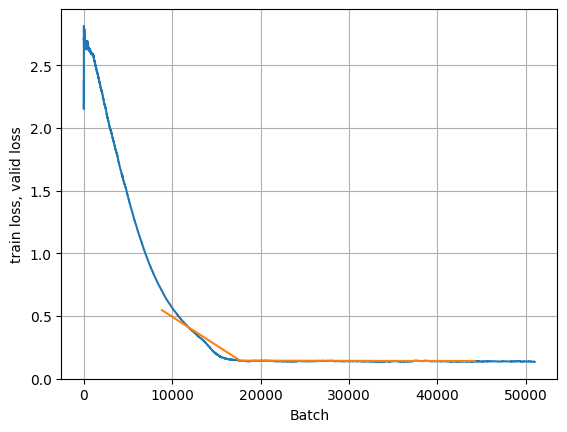

In [36]:
learner.recorder.plot("train loss", "valid loss")

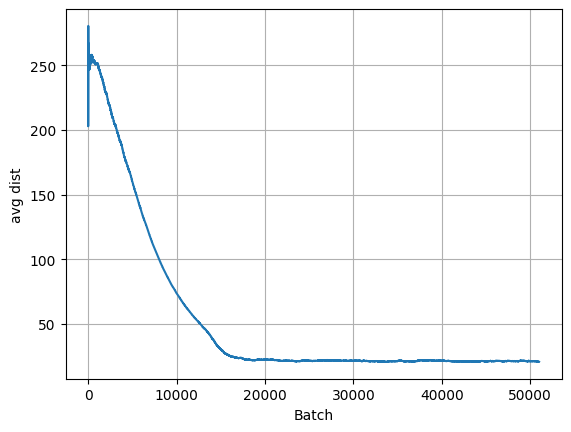

In [37]:
learner.recorder.plot("avg dist")